# Part 2. Practice

#### 1.	Given https://github.com/yutkin/Lenta.Ru-News-Dataset, perform EDA on it focusing on the following:
-	Provide descriptive statistics
-	Anomaly detection   

#### 2.	Given the same dataset,
-		extract the most syntactically weighted N-grams, omitting nonsense (‘казалось бы’, ‘возможно предположить’, etc). The main idea is to extract the most valuable data from the text.
-	Try different models for a topic extraction. Which one performs better? What metrics were used to evaluate the model?

#### Import libraries

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=True)
sns.set()
sns.set_palette('husl')

import numpy as np
import pandas as pd

import re
import string
from collections import defaultdict

import nltk
from nltk.corpus import stopwords
from nltk.util import ngrams

import gensim
import pyLDAvis
import pyLDAvis.gensim

import stop_words

from pymystem3 import Mystem
from pymorphy2 import MorphAnalyzer

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.model_selection import train_test_split

import warnings
warnings.simplefilter('ignore')

#### Load and prepare dataset

#### Source of data:
https://www.kaggle.com/yutkin/corpus-of-russian-news-articles-from-lenta/

In [2]:
%%time
data = pd.read_csv('train_data.csv')

Wall time: 23.3 s


In order to save time I chose four topics neither too large nor too small.

In [3]:
topics = ['Экономика', 'Спорт', 'Культура', 'Наука и техника']

In [4]:
data = data.loc[data['topic'].isin(topics)]

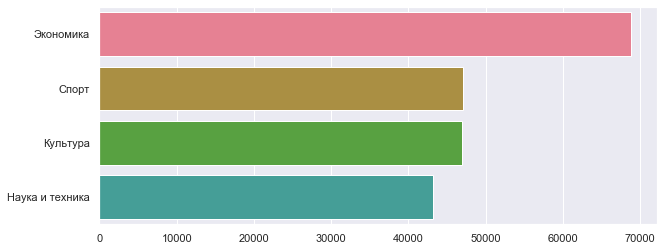

In [5]:
plt.figure(figsize=(10,4))
sns.barplot(x=data.topic.value_counts().values, y=data.topic.value_counts().index);

# The most syntactically weighted N-grams extracting

## Text preprocessing

### Lowercase Text

In [6]:
data['processed_text'] = data['text'].str.lower()

### Removing Text Noise

In [7]:
%%time
def remove_noise(text):
    'Removing punctuation, html tags, symbols, numbers, etc.'
    text = re.sub('https?://\S+|www\.\S+', ' ', text)
    text = re.sub(r'[^\w\s]',' ', text)
    text = re.sub(r'[0-9]+', ' ', text)
    text = re.sub('\n', ' ', text)
    text = re.sub('\sне', 'не', text)
    return text


data['processed_text'] = data['processed_text'].apply(
    lambda x: remove_noise(x)
)
data['processed_text'].head(2)

Wall time: 17.9 s


536    с   января   года все телеканалы будут оплачив...
541    германский автопромышленный концерн volkswagen...
Name: processed_text, dtype: object

### Removing Stopwords

In [8]:
%%time
STOPWORDS = set(stop_words.get_stop_words('ru'))


def remove_stopwords(text, stopwords):
    token = [token for token in text.split() if token not in stopwords]
    return token
    
    
data['processed_text'] = data['processed_text'].apply(
    lambda x:  (remove_stopwords(x, STOPWORDS))
)
data['processed_text'].head(2)

Wall time: 8.02 s


536    [января, телеканалы, оплачивать, услуги, перед...
541    [германский, автопромышленный, концерн, volksw...
Name: processed_text, dtype: object

### Only keep the words that appear more than 20 times

In [9]:
%%time
def remove_outlier(texts):
    # Count word frequencies
    frequency = defaultdict(int)
    for text in texts:
        for token in text:
            frequency[token] += 1

    result = [[token for token in text if frequency[token] > 20] for text in texts]
    return result


data['processed_text'] = remove_outlier(data['processed_text'])
data['processed_text'].head(2)

Wall time: 14.7 s


536    [января, телеканалы, оплачивать, услуги, перед...
541    [германский, концерн, volkswagen, намерен, пол...
Name: processed_text, dtype: object

### Lemmatization

In [10]:
%%time
morpher = MorphAnalyzer()
data['processed_text'] = data['processed_text'].apply(
    lambda x:  [morpher.parse(word)[0].normal_form for word in x]
)
data['processed_text'].head(2)

Wall time: 50min 25s


536    [январь, телеканал, оплачивать, услуга, переда...
541    [германский, концерн, volkswagen, намеренный, ...
Name: processed_text, dtype: object

### Stemming

In [11]:
# %%time
# stemmer = nltk.stem.snowball.RussianStemmer()


# def stemming_seq(text, stemmer):
#     result = []
#     for token in text:
#         result.append(stemmer.stem(token))
#     return result
    
    
# data['processed_text'] = data['processed_text'].apply(
#     lambda x:  stemming_seq(x, stemmer)
# )
# data['processed_text'].head(2)

# N-grams

In [12]:
N=20

In [13]:
def generate_ngrams(text, n_gram=1):
    ngrams = zip(*[text[i:] for i in range(n_gram)])
    return [' '.join(ngram) for ngram in ngrams]

#### Unigrams

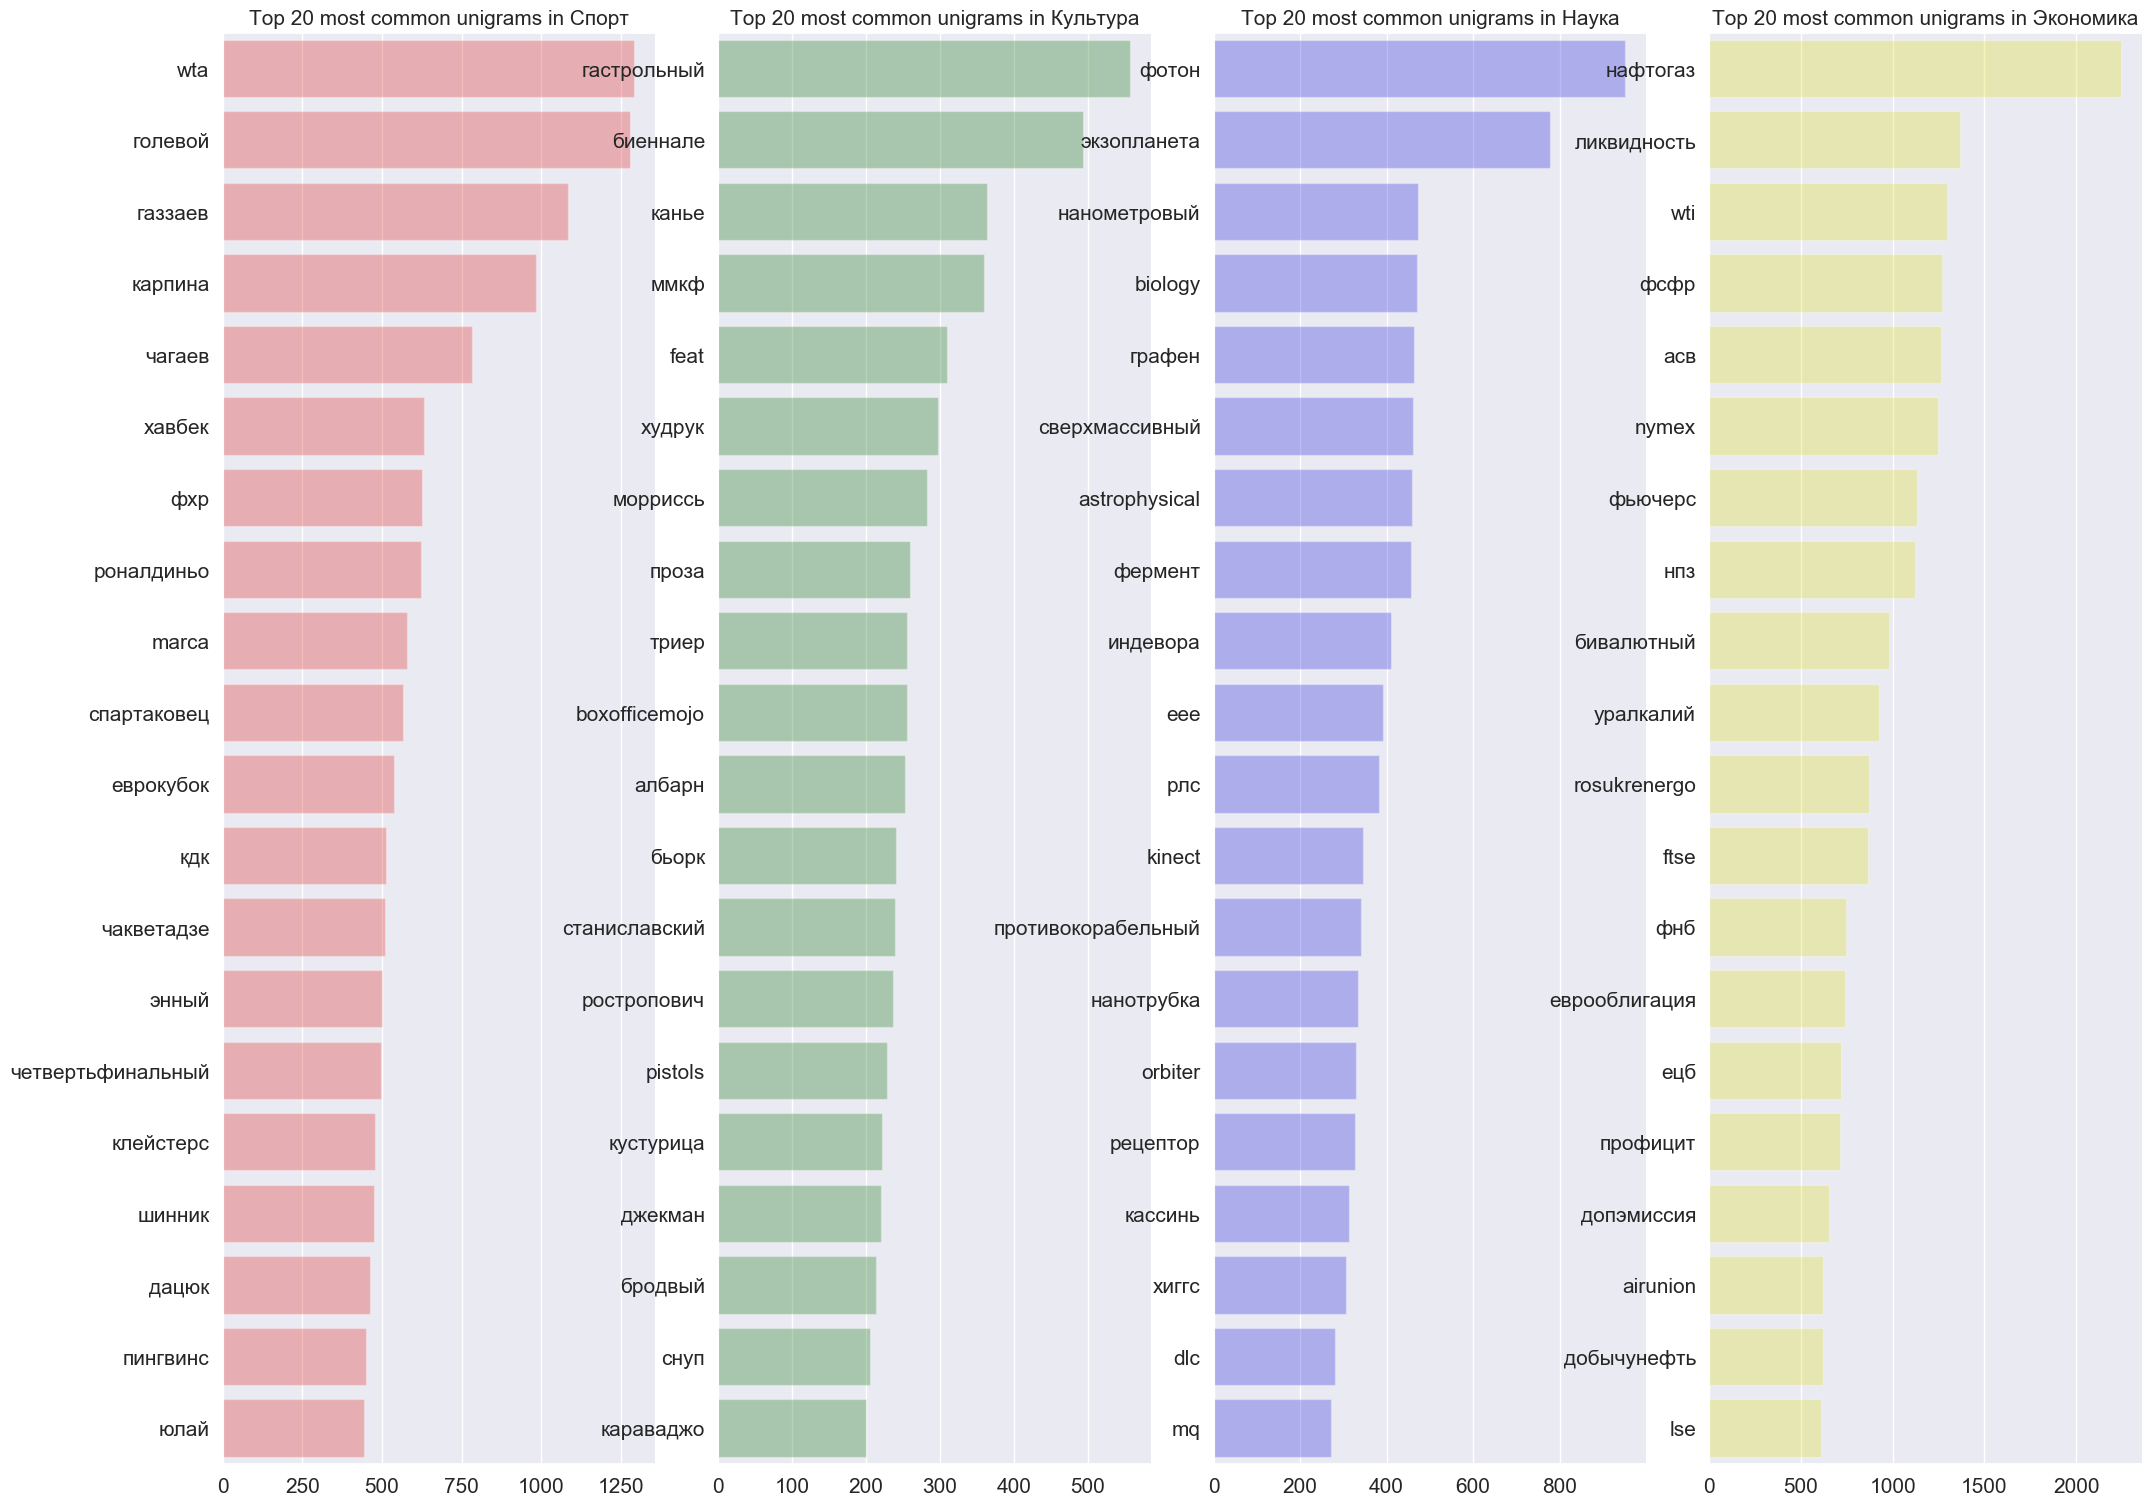

In [14]:
# unigrams on every topic and their frequencies
sport_unigrams = defaultdict(int)
culture_unigrams = defaultdict(int)
sci_unigrams = defaultdict(int)
economy_unigrams = defaultdict(int)

for text in data.loc[data['topic'] == 'Спорт', 'processed_text']:
    for word in generate_ngrams(text):
        sport_unigrams[word] += 1
        
for text in data.loc[data['topic'] == 'Культура', 'processed_text']:
    for word in generate_ngrams(text):        
        culture_unigrams[word] += 1
        
for text in data.loc[data['topic'] == 'Наука и техника', 'processed_text']:
    for word in generate_ngrams(text):   
        sci_unigrams[word] += 1
        
for text in data.loc[data['topic'] == 'Экономика', 'processed_text']:
    for word in generate_ngrams(text):   
        economy_unigrams[word] += 1

# sets of unigrams on every topic
sport_unigrams_keys = set(sport_unigrams.keys())
culture_unigrams_keys = set(culture_unigrams.keys())
sci_unigrams_keys = set(sci_unigrams.keys())
economy_unigrams_keys = set(economy_unigrams.keys())

# unique unigrams on every topic
unique_sport_unigrams = sport_unigrams_keys - culture_unigrams_keys - sci_unigrams_keys - economy_unigrams_keys
unique_sport_unigrams = {k : v for k, v in iter(sport_unigrams.items()) if k in unique_sport_unigrams}

unique_culture_unigrams = culture_unigrams_keys - sci_unigrams_keys - economy_unigrams_keys - sport_unigrams_keys
unique_culture_unigrams = {k : v for k, v in iter(culture_unigrams.items()) if k in unique_culture_unigrams}

unique_sci_unigrams = sci_unigrams_keys - economy_unigrams_keys - sport_unigrams_keys - culture_unigrams_keys
unique_sci_unigrams = {k : v for k, v in iter(sci_unigrams.items()) if k in unique_sci_unigrams}

unique_economy_unigrams = economy_unigrams_keys - sport_unigrams_keys - culture_unigrams_keys - sci_unigrams_keys
unique_economy_unigrams = {k : v for k, v in iter(economy_unigrams.items()) if k in unique_economy_unigrams}

# datasets with the unique unigrams and their frequencies
df_sport_unigrams = pd.DataFrame(sorted(unique_sport_unigrams.items(), key=lambda x: x[1])[::-1])
df_culture_unigrams = pd.DataFrame(sorted(unique_culture_unigrams.items(), key=lambda x: x[1])[::-1])
df_sci_unigrams = pd.DataFrame(sorted(unique_sci_unigrams.items(), key=lambda x: x[1])[::-1])
df_economy_unigrams = pd.DataFrame(sorted(unique_economy_unigrams.items(), key=lambda x: x[1])[::-1])

# 20 most popular unigrams per topic
fig, axes = plt.subplots(ncols=4, figsize=(20, 15), dpi=100)
plt.tight_layout()

sns.barplot(
    y=df_sport_unigrams[0].values[:N], 
    x=df_sport_unigrams[1].values[:N], 
    ax=axes[0], 
    color='red', 
    alpha=0.3
)
sns.barplot(
    y=df_culture_unigrams[0].values[:N], 
    x=df_culture_unigrams[1].values[:N], 
    ax=axes[1], 
    color='green', 
    alpha=0.3
)
sns.barplot(
    y=df_sci_unigrams[0].values[:N], 
    x=df_sci_unigrams[1].values[:N], 
    ax=axes[2], 
    color='blue', 
    alpha=0.3
)
sns.barplot(
    y=df_economy_unigrams[0].values[:N], 
    x=df_economy_unigrams[1].values[:N], 
    ax=axes[3], 
    color='yellow', 
    alpha=0.3
)

for i in range(4):
    axes[i].spines['right'].set_visible(False)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')
    axes[i].tick_params(axis='x', labelsize=15)
    axes[i].tick_params(axis='y', labelsize=15)

axes[0].set_title(f'Top {N} most common unigrams in Спорт', fontsize=15)
axes[1].set_title(f'Top {N} most common unigrams in Культура', fontsize=15)
axes[2].set_title(f'Top {N} most common unigrams in Наука', fontsize=15)
axes[3].set_title(f'Top {N} most common unigrams in Экономика', fontsize=15)

plt.show()

#### Bigrams

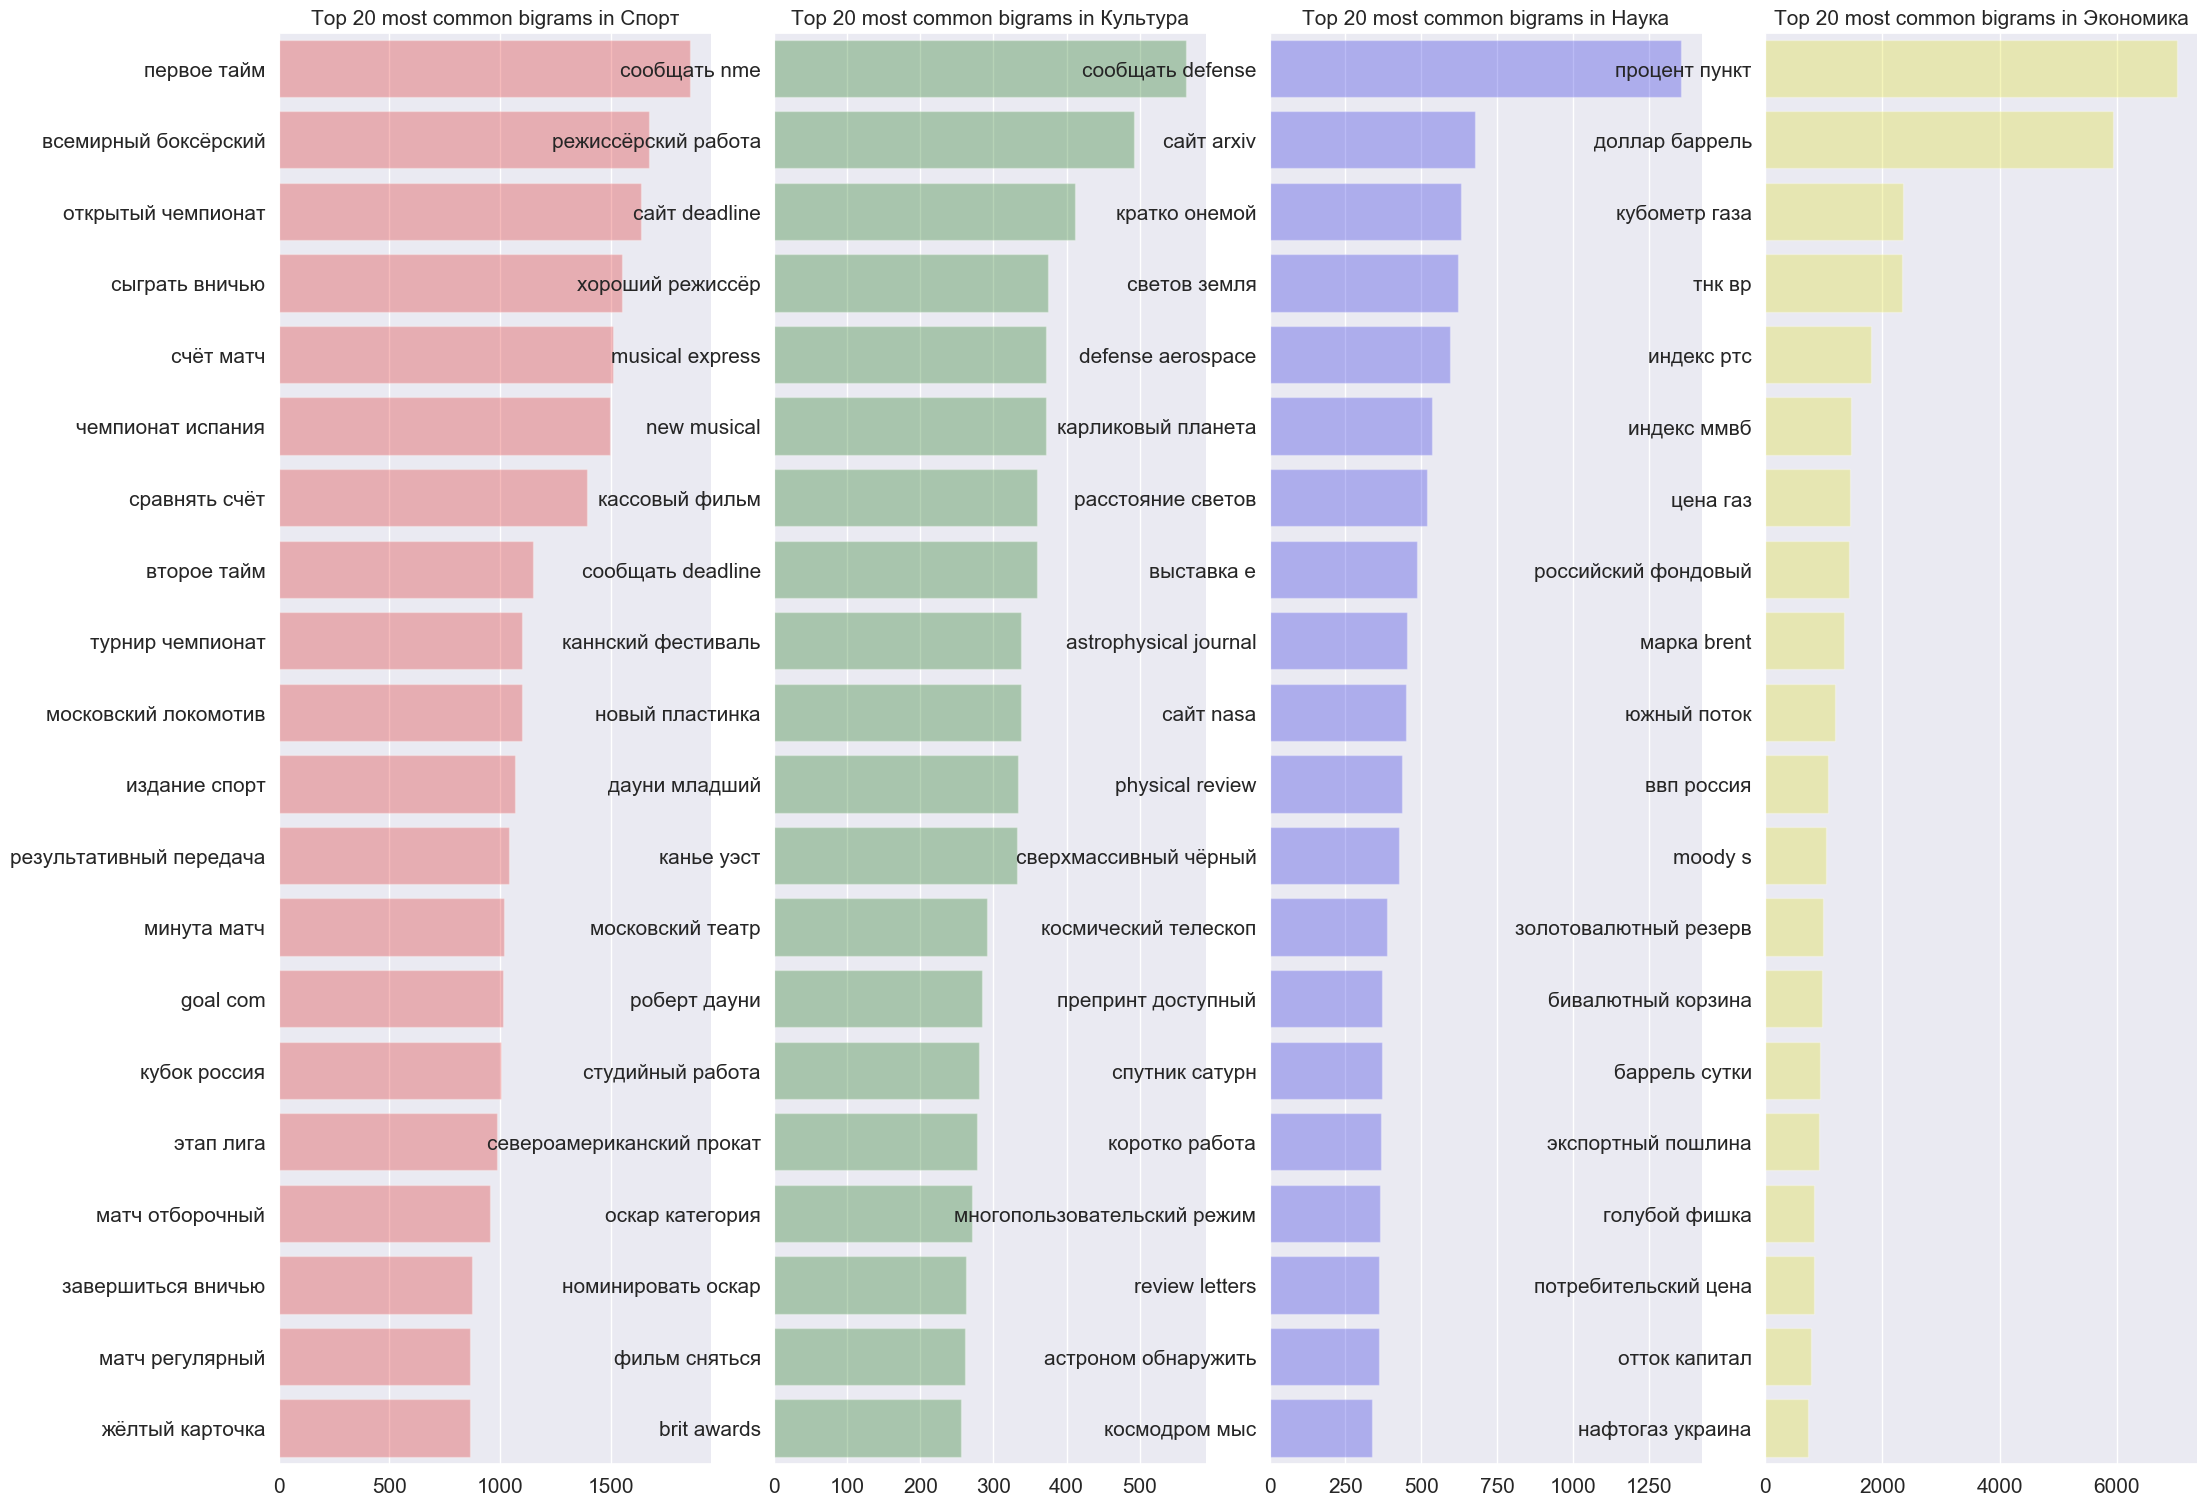

In [15]:
# Bigrams
sport_bigrams = defaultdict(int)
culture_bigrams = defaultdict(int)
sci_bigrams = defaultdict(int)
economy_bigrams = defaultdict(int)

for text in data.loc[data['topic'] == 'Спорт', 'processed_text']:
    for word in generate_ngrams(text, 2):
        sport_bigrams[word] += 1
        
for text in data.loc[data['topic'] == 'Культура', 'processed_text']:
    for word in generate_ngrams(text, 2):        
        culture_bigrams[word] += 1
        
for text in data.loc[data['topic'] == 'Наука и техника', 'processed_text']:
    for word in generate_ngrams(text, 2):   
        sci_bigrams[word] += 1
        
for text in data.loc[data['topic'] == 'Экономика', 'processed_text']:
    for word in generate_ngrams(text, 2):   
        economy_bigrams[word] += 1

sport_bigrams_keys = set(sport_bigrams.keys())
culture_bigrams_keys = set(culture_bigrams.keys())
sci_bigrams_keys = set(sci_bigrams.keys())
economy_bigrams_keys = set(economy_bigrams.keys())

unique_sport_bigrams = sport_bigrams_keys - culture_bigrams_keys - sci_bigrams_keys - economy_bigrams_keys
unique_sport_bigrams = {k : v for k, v in iter(sport_bigrams.items()) if k in unique_sport_bigrams}

unique_culture_bigrams = culture_bigrams_keys - sci_bigrams_keys - economy_bigrams_keys - sport_bigrams_keys
unique_culture_bigrams = {k : v for k, v in iter(culture_bigrams.items()) if k in unique_culture_bigrams}

unique_sci_bigrams = sci_bigrams_keys - economy_bigrams_keys - sport_bigrams_keys - culture_bigrams_keys
unique_sci_bigrams = {k : v for k, v in iter(sci_bigrams.items()) if k in unique_sci_bigrams}

unique_economy_bigrams = economy_bigrams_keys - sport_bigrams_keys - culture_bigrams_keys - sci_bigrams_keys
unique_economy_bigrams = {k : v for k, v in iter(economy_bigrams.items()) if k in unique_economy_bigrams}

df_sport_bigrams = pd.DataFrame(sorted(unique_sport_bigrams.items(), key=lambda x: x[1])[::-1])
df_culture_bigrams = pd.DataFrame(sorted(unique_culture_bigrams.items(), key=lambda x: x[1])[::-1])
df_sci_bigrams = pd.DataFrame(sorted(unique_sci_bigrams.items(), key=lambda x: x[1])[::-1])
df_economy_bigrams = pd.DataFrame(sorted(unique_economy_bigrams.items(), key=lambda x: x[1])[::-1])

fig, axes = plt.subplots(ncols=4, figsize=(20, 15), dpi=100)
plt.tight_layout()

sns.barplot(
    y=df_sport_bigrams[0].values[:N], 
    x=df_sport_bigrams[1].values[:N], 
    ax=axes[0], 
    color='red',
    alpha=0.3
)
sns.barplot(
    y=df_culture_bigrams[0].values[:N], 
    x=df_culture_bigrams[1].values[:N], 
    ax=axes[1], 
    color='green', 
    alpha=0.3
)
sns.barplot(
    y=df_sci_bigrams[0].values[:N], 
    x=df_sci_bigrams[1].values[:N], 
    ax=axes[2], 
    color='blue', 
    alpha=0.3
)
sns.barplot(
    y=df_economy_bigrams[0].values[:N], 
    x=df_economy_bigrams[1].values[:N], 
    ax=axes[3], 
    color='yellow', 
    alpha=0.3
)

for i in range(4):
    axes[i].spines['right'].set_visible(False)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')
    axes[i].tick_params(axis='x', labelsize=15)
    axes[i].tick_params(axis='y', labelsize=15)

axes[0].set_title(f'Top {N} most common bigrams in Спорт', fontsize=15)
axes[1].set_title(f'Top {N} most common bigrams in Культура', fontsize=15)
axes[2].set_title(f'Top {N} most common bigrams in Наука', fontsize=15)
axes[3].set_title(f'Top {N} most common bigrams in Экономика', fontsize=15)

plt.show()

#### Trigrams

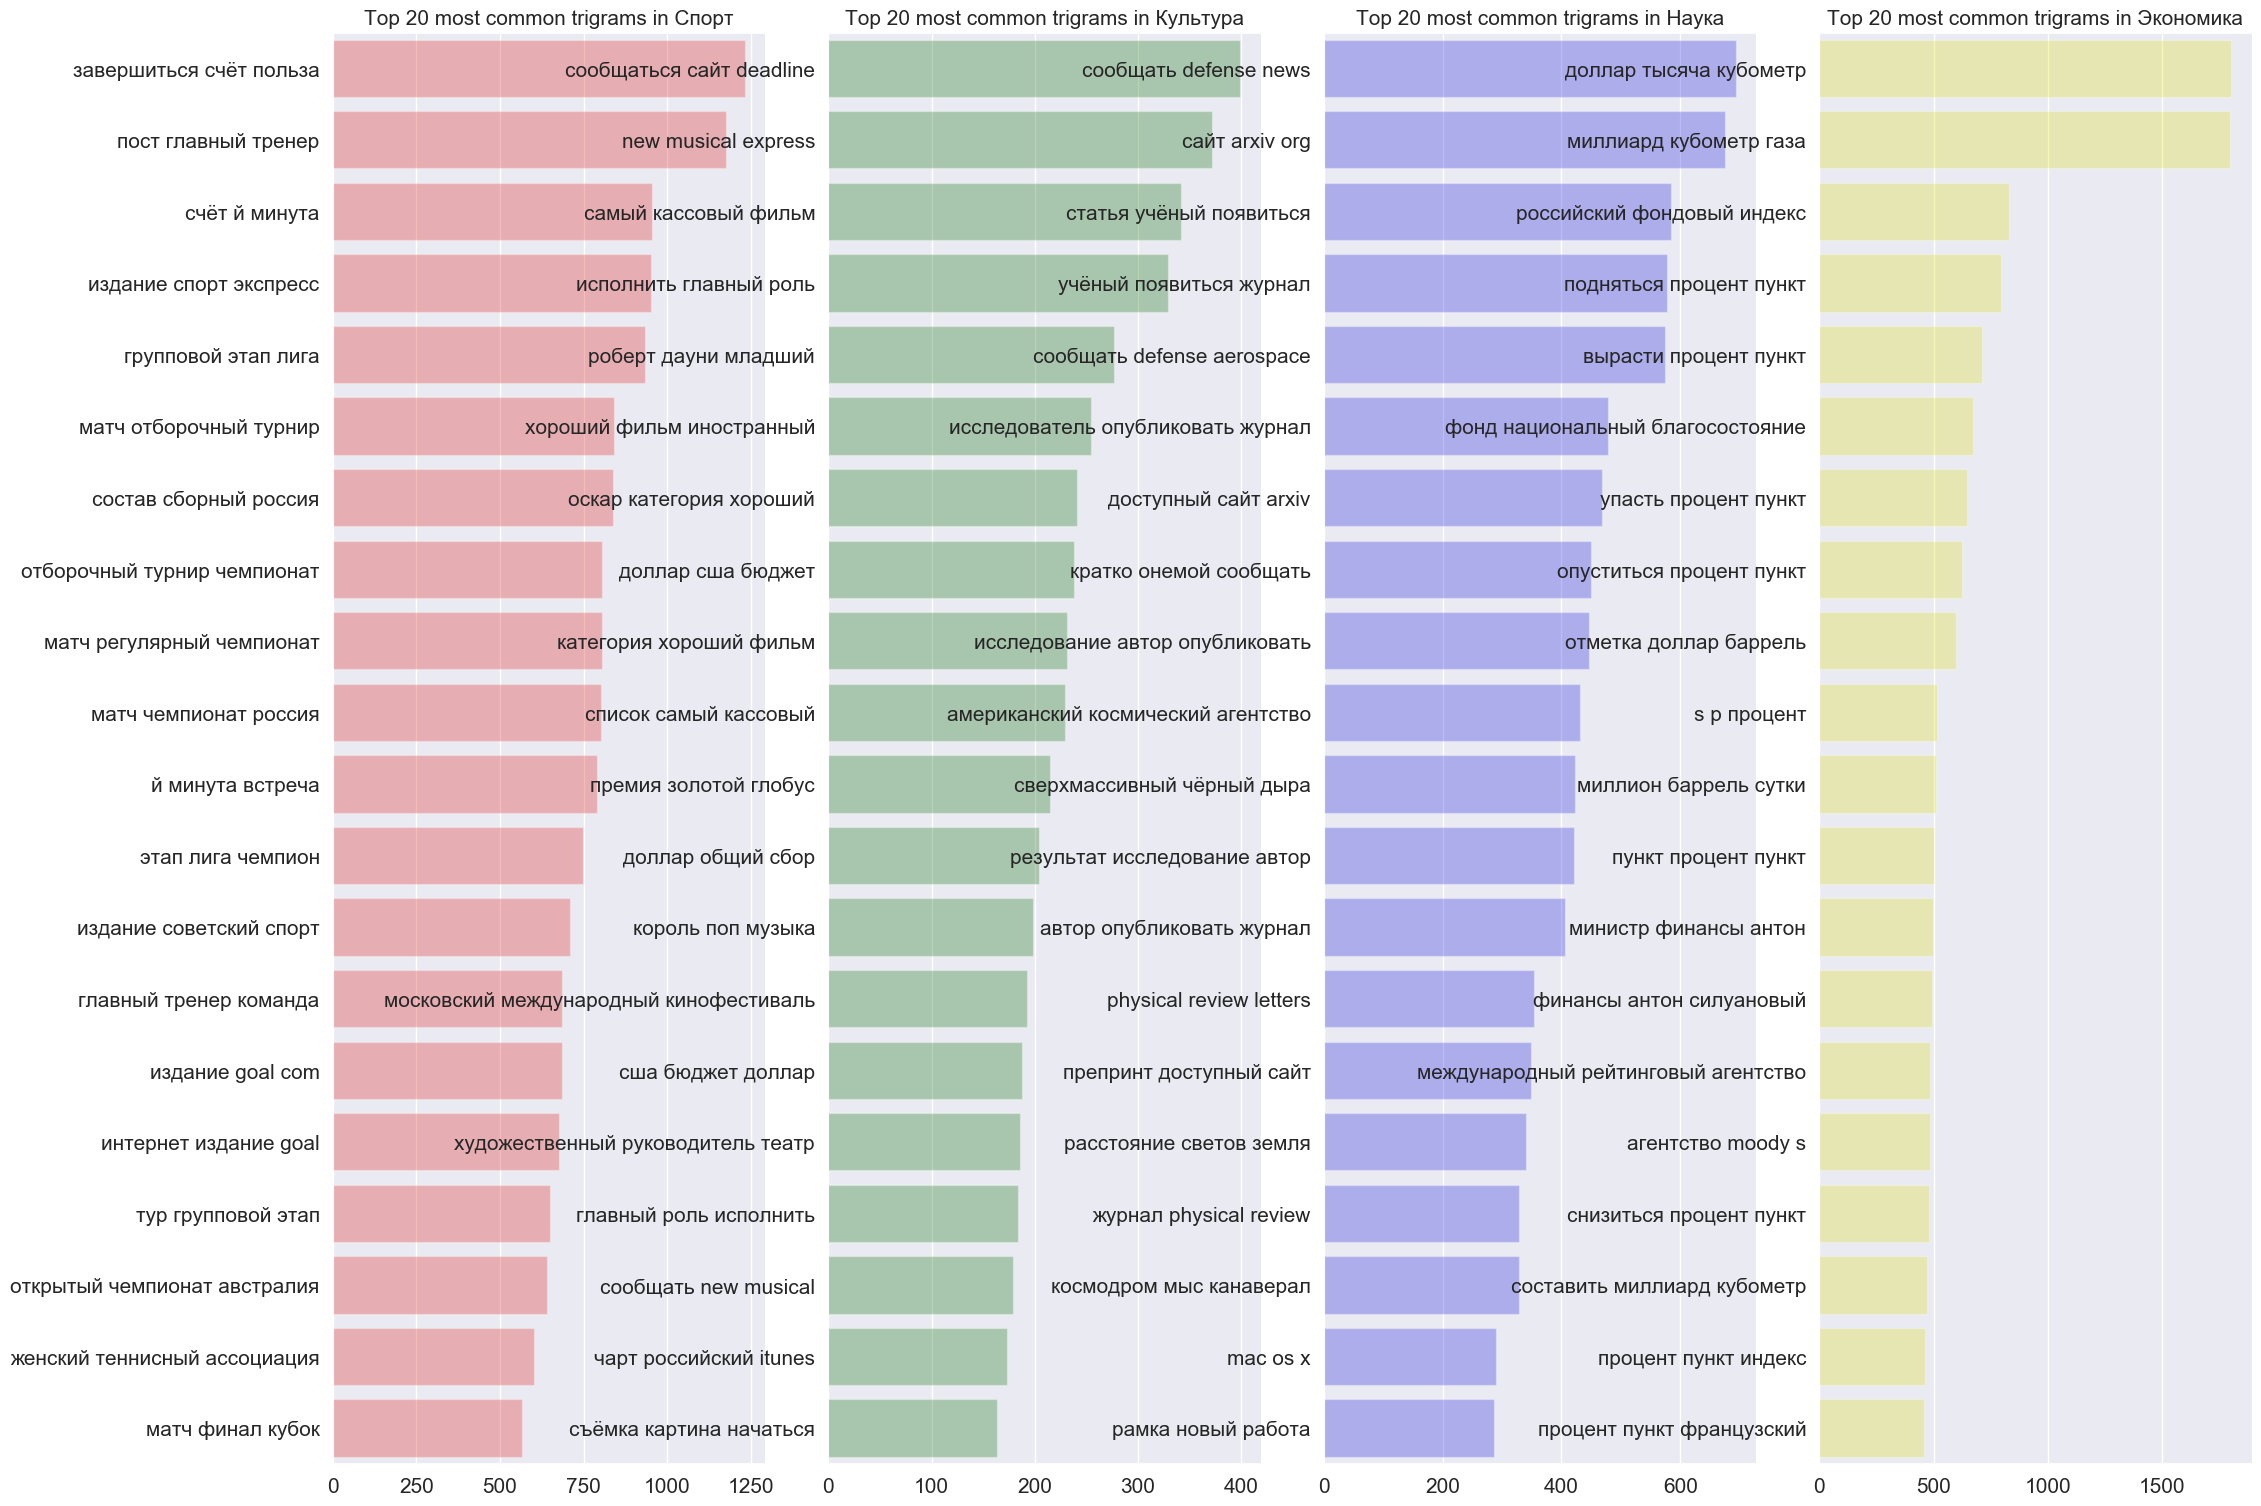

In [16]:
# Trigrams
sport_trigrams = defaultdict(int)
culture_trigrams = defaultdict(int)
sci_trigrams = defaultdict(int)
economy_trigrams = defaultdict(int)

for text in data.loc[data['topic'] == 'Спорт', 'processed_text']:
    for word in generate_ngrams(text, 3):
        sport_trigrams[word] += 1
        
for text in data.loc[data['topic'] == 'Культура', 'processed_text']:
    for word in generate_ngrams(text, 3):        
        culture_trigrams[word] += 1
        
for text in data.loc[data['topic'] == 'Наука и техника', 'processed_text']:
    for word in generate_ngrams(text, 3):   
        sci_trigrams[word] += 1
        
for text in data.loc[data['topic'] == 'Экономика', 'processed_text']:
    for word in generate_ngrams(text, 3):   
        economy_trigrams[word] += 1

sport_trigrams_keys = set(sport_trigrams.keys())
culture_trigrams_keys = set(culture_trigrams.keys())
sci_trigrams_keys = set(sci_trigrams.keys())
economy_trigrams_keys = set(economy_trigrams.keys())

unique_sport_trigrams = sport_trigrams_keys - culture_trigrams_keys - sci_trigrams_keys - economy_trigrams_keys
unique_sport_trigrams = {k : v for k, v in iter(sport_trigrams.items()) if k in unique_sport_trigrams}

unique_culture_trigrams = culture_trigrams_keys - sci_trigrams_keys - economy_trigrams_keys - sport_trigrams_keys
unique_culture_trigrams = {k : v for k, v in iter(culture_trigrams.items()) if k in unique_culture_trigrams}

unique_sci_trigrams = sci_trigrams_keys - economy_trigrams_keys - sport_trigrams_keys - culture_trigrams_keys
unique_sci_trigrams = {k : v for k, v in iter(sci_trigrams.items()) if k in unique_sci_trigrams}

unique_economy_trigrams = economy_trigrams_keys - sport_trigrams_keys - culture_trigrams_keys - sci_trigrams_keys
unique_economy_trigrams = {k : v for k, v in iter(economy_trigrams.items()) if k in unique_economy_trigrams}

df_sport_trigrams = pd.DataFrame(sorted(unique_sport_trigrams.items(), key=lambda x: x[1])[::-1])
df_culture_trigrams = pd.DataFrame(sorted(unique_culture_trigrams.items(), key=lambda x: x[1])[::-1])
df_sci_trigrams = pd.DataFrame(sorted(unique_sci_trigrams.items(), key=lambda x: x[1])[::-1])
df_economy_trigrams = pd.DataFrame(sorted(unique_economy_trigrams.items(), key=lambda x: x[1])[::-1])

fig, axes = plt.subplots(ncols=4, figsize=(20, 15), dpi=100)
plt.tight_layout()

sns.barplot(
    y=df_sport_trigrams[0].values[:N], 
    x=df_sport_trigrams[1].values[:N], 
    ax=axes[0], 
    color='red', 
    alpha=0.3
)
sns.barplot(
    y=df_culture_trigrams[0].values[:N], 
    x=df_culture_trigrams[1].values[:N], 
    ax=axes[1], 
    color='green', 
    alpha=0.3
)
sns.barplot(
    y=df_sci_trigrams[0].values[:N], 
    x=df_sci_trigrams[1].values[:N], 
    ax=axes[2], 
    color='blue', 
    alpha=0.3
)
sns.barplot(
    y=df_economy_trigrams[0].values[:N], 
    x=df_economy_trigrams[1].values[:N], 
    ax=axes[3], 
    color='yellow', 
    alpha=0.3
)

for i in range(4):
    axes[i].spines['right'].set_visible(False)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')
    axes[i].tick_params(axis='x', labelsize=15)
    axes[i].tick_params(axis='y', labelsize=15)

axes[0].set_title(f'Top {N} most common trigrams in Спорт', fontsize=15)
axes[1].set_title(f'Top {N} most common trigrams in Культура', fontsize=15)
axes[2].set_title(f'Top {N} most common trigrams in Наука', fontsize=15)
axes[3].set_title(f'Top {N} most common trigrams in Экономика', fontsize=15)

plt.show()

## N-grams using NLTK

In [17]:
%%time
data['bigrams'] = data['processed_text'].apply(lambda x: list(ngrams(x, 2)))
data['bigrams'].head()

Wall time: 12.1 s


536    [(январь, телеканал), (телеканал, оплачивать),...
541    [(германский, концерн), (концерн, volkswagen),...
542    [(прибыль, оао), (оао, дочерний), (дочерний, п...
564    [(крупный, телекоммуникационный), (телекоммуни...
565    [(оао, газ), (газ, нижегородский), (нижегородс...
Name: bigrams, dtype: object

In [18]:
data['trigrams'] = data['processed_text'].apply(lambda x: list(ngrams(x, 3)))
data['trigrams'].head()

536    [(январь, телеканал, оплачивать), (телеканал, ...
541    [(германский, концерн, volkswagen), (концерн, ...
542    [(прибыль, оао, дочерний), (оао, дочерний, пре...
564    [(крупный, телекоммуникационный, компания), (т...
565    [(оао, газ, нижегородский), (газ, нижегородски...
Name: trigrams, dtype: object

# Topic extraction with Tensorflow

In [19]:
topics = data['topic'].unique()
topics

array(['Экономика', 'Спорт', 'Культура', 'Наука и техника'], dtype=object)

In [20]:
replace_dict = {topics[i]: i for i in range(len(topics))}  # topics' names to numbers dict

data['topic'].replace(replace_dict, inplace=True)  # changing names for numbers

#### Training and validating datasets

In [21]:
X = data['processed_text']
y = data['topic'].tolist()

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)

X_train.shape, len(y_train)

((137995,), 137995)

In [22]:
import tensorflow as tf
print(tf.__version__)

2.2.0


In [23]:
from tensorflow.python.client import device_lib

def get_available_gpus():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos if x.device_type == 'GPU']

get_available_gpus()

['/device:GPU:0']

#### Pre-Processing

In [24]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [25]:
tokenizer = Tokenizer(oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)  
word_index = tokenizer.word_index
print(len(word_index))

34189


In [26]:
X_train = tokenizer.texts_to_sequences(X_train)
X_train = pad_sequences(X_train, padding='post')
print(X_train[0])
print(X_train.shape)

[24491 19075  2048   309   127   565   886    38  5483   242   328   310
  2459 19521 19075   267    68    26   969   260  1639  2153 15567   278
    51   130   749 23231  1396   964 19075   749  1616   969   414   821
     2   259    26   267  2596  8581 24053   747 19075   749     8     6
   369     8  1201    90    51   243  1204   278  3350   267    26 30666
 24492    12   251  3402  8063   267    26  2189  9477   278   251    51
 19075    23    38 19521   309  5886 28996   120    26   267 23231   147
  2459   747  1024   532   969     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0   

In [27]:
X_test = tokenizer.texts_to_sequences(X_test)
X_test = pad_sequences(X_test, padding='post')

In [28]:
BUFFER_SIZE = X_train.shape[0]
BATCH_SIZE = 64

train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.padded_batch(BATCH_SIZE)

In [29]:
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))
test_dataset = test_dataset.padded_batch(BATCH_SIZE)

#### Building the model

In [30]:
vocab_size = len(word_index)
embedding_dim = 64

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size+1, embedding_dim),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(4, activation='sigmoid')
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 64)          2188160   
_________________________________________________________________
global_average_pooling1d (Gl (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 32)                2080      
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 132       
Total params: 2,190,372
Trainable params: 2,190,372
Non-trainable params: 0
_________________________________________________________________


In [31]:
%%time
num_epochs = 5
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(
    train_dataset, 
    epochs=num_epochs, 
    validation_data=test_dataset)

Epoch 1/5
2157/2157 [==============================] - 69s 32ms/step - loss: 0.1858 - accuracy: 0.9358 - val_loss: 0.0542 - val_accuracy: 0.9829
Epoch 2/5
2157/2157 [==============================] - 67s 31ms/step - loss: 0.0384 - accuracy: 0.9875 - val_loss: 0.0502 - val_accuracy: 0.9832
Epoch 3/5
2157/2157 [==============================] - 68s 31ms/step - loss: 0.0252 - accuracy: 0.9916 - val_loss: 0.0465 - val_accuracy: 0.9840
Epoch 4/5
2157/2157 [==============================] - 68s 32ms/step - loss: 0.0162 - accuracy: 0.9951 - val_loss: 0.0519 - val_accuracy: 0.9837
Epoch 5/5
2157/2157 [==============================] - 68s 31ms/step - loss: 0.0101 - accuracy: 0.9970 - val_loss: 0.0535 - val_accuracy: 0.9840
Wall time: 5min 57s


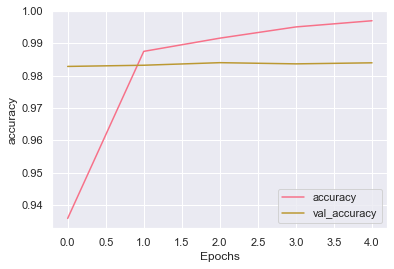

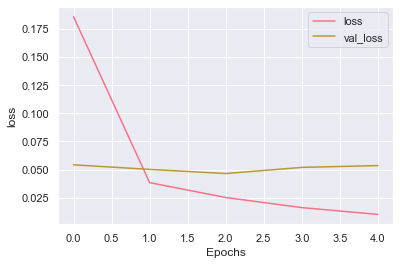

In [32]:
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()
    
    
plot_graphs(history, "accuracy")  # Plot training and validation accuracy per epoch
plot_graphs(history, "loss")  # Plot training and validation loss per epoch

As you can see, the elementary model shows a very good result.

I believe that Logistic Regression should successfully handle this task.

# Topic extraction with Gensim

In [33]:
docs = X.tolist()

In [34]:
len(docs)

205964

#### Compute bigrams

In [35]:
from gensim.models import Phrases
bigram = Phrases(docs, min_count=20)

In [36]:
# Add bigrams to docs (only ones that appear 20 times or more).
for idx in range(len(docs)):
    for token in bigram[docs[idx]]:
        if '_' in token:
            # Token is a bigram, add to document.
            docs[idx].append(token)

#### Remove rare and common tokens

In [37]:
from gensim.corpora import Dictionary

# Create a dictionary representation of the documents.
dictionary = Dictionary(docs)
len(dictionary)

68113

In [38]:
# Filter out words that occur less than 20 documents, or more than 50% of the documents.
dictionary.filter_extremes(no_below=20, no_above=0.5)
len(dictionary)

59759

#### Bag-of-words representation of the documents

In [39]:
corpus = [dictionary.doc2bow(doc) for doc in docs]

#### Train LDA model

In [40]:
%%time
from gensim.models import LdaModel

# Set training parameters.
num_topics = 4
chunksize = 2000
passes = 20
iterations = 400
eval_every = None  

# Make an index to word dictionary.
temp = dictionary[0]  # This is only to "load" the dictionary.
id2word = dictionary.id2token

model = LdaModel(
    corpus=corpus,
    id2word=id2word,
    chunksize=chunksize,
    alpha='auto',
    eta='auto',
    iterations=iterations,
    num_topics=num_topics,
    passes=passes,
    eval_every=eval_every
)

Wall time: 25min 10s


In [41]:
model.print_topics()

[(0,
  '0.007*"фильм" + 0.006*"учёный" + 0.004*"группа" + 0.003*"один" + 0.003*"актёр" + 0.003*"опубликовать" + 0.003*"the" + 0.003*"лента" + 0.003*"картина" + 0.003*"человек"'),
 (1,
  '0.015*"матч" + 0.011*"команда" + 0.010*"клуб" + 0.010*"чемпионат" + 0.008*"россия" + 0.008*"футболист" + 0.007*"сборный" + 0.006*"лига" + 0.006*"счёт" + 0.005*"футбольный"'),
 (2,
  '0.007*"космический" + 0.007*"компания" + 0.007*"ракета" + 0.006*"сша" + 0.005*"спутник" + 0.005*"китай" + 0.005*"американский" + 0.005*"корабль" + 0.004*"система" + 0.004*"аппарат"'),
 (3,
  '0.013*"россия" + 0.008*"рубль" + 0.007*"миллиард" + 0.007*"доллар" + 0.007*"российский" + 0.007*"процент" + 0.006*"компания" + 0.006*"страна" + 0.005*"заявить" + 0.004*"украина"')]

As you can see the model successfully extracted the topics from the corpus that correlate with the target topics.

In [42]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(model, corpus, dictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.092716  0.131411       1        1  35.702881
0      0.008016 -0.218326       2        1  30.980761
1      0.271710  0.065809       3        1  18.531082
2     -0.187010  0.021106       4        1  14.785278, topic_info=            Term          Freq          Total Category  logprob  loglift
9818        матч  72848.000000   72848.000000  Default  30.0000  30.0000
4439     команда  56792.000000   56792.000000  Default  29.0000  29.0000
962         клуб  51162.000000   51162.000000  Default  28.0000  28.0000
9976   чемпионат  48228.000000   48228.000000  Default  27.0000  27.0000
145        рубль  77509.000000   77509.000000  Default  26.0000  26.0000
...          ...           ...            ...      ...      ...      ...
185       доллар  15440.104492   87603.562500   Topic4  -5.5356   0.1757
477        новый  12436.962891   49069.429688   Topic4  -5.7519   0.5390
23    российский  14679.529297  107907.625000   Topic4  -5.5861  -0.0833
170    агентство  10484.245117   28914.570312   Topic4  -5.9227   0.8971
184      должный  10643.969727   41903.058594   Topic4  -5.9075   0.5412

[266 rows x 6 columns], token_table=       Topic      Freq           Term
term                                 
25210      2  0.000399          apple
25210      4  0.999479          apple
3828       4  0.999645         boeing
639        4  0.999842          brent
18685      4  0.999871         falcon
...      ...       ...            ...
1362       4  0.001542  экономический
39         1  0.357123       являться
39         2  0.381567       являться
39         3  0.113361       являться
39         4  0.147927       являться

[457 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 1, 2, 3])